<h1>WEST case study - Parabolic Profile</h1>

In [1]:
import numpy as np
import cmath as cm

from scipy.fft import fft,fftfreq
from scipy.interpolate import make_smoothing_spline

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import clear_output

import copy
from timeit import default_timer as timer
import pandas as pd

np.random.seed(2024061) # For reproducibility

import import_ipynb
from WavesPlasma import *

Nx     = 6000
p0plas = 50
k00    = 0.025
ν      = 84 
wpe2_,wc_ = freq_dicts(Nx,k00,p0plas)
# Profile reconstruction
#β      = 27.9

importing Jupyter notebook from WavesPlasma.ipynb


<h3>WEST's parameters and confined plasma - Parabolic approximation</h3>

The parabolic electron density approximation is as follows

\begin{equation}
    n_e(\rho)=n_{e0}\sqrt{1-\rho^2}
\end{equation}

where $\rho=\frac{R-R_0}{a}$ and $x_\mathrm{sim}=2\frac{1-\rho^2}{w_\mathrm{th}}$ with $R_0=2.5$ m, $a=0.5$ m being dimension parameters of WEST and $w_\mathrm{th}=0.05$ is a parameter of the density approximation. $R$ is the position in the tokamak radius (plasma is confined approximately between $R=2$ m and $R=3$ m).

We also consider the magnetic field, which will be given by

\begin{equation}
    B(R)=\frac{3.7R_0}{R}\ ,
\end{equation}

where $R$ is in units of m and $B$ in units of T.


In [2]:
ne0      = 5e5  # (1e14) m^{-3}
neped    = 1e5  # (1e14) m^{-3}
neoffset = 1    # (1e14) m^{-3}
nefactor = 1e14

R0  = 2.5     # meters
a   = 0.5     # meters
wth = 0.05    # adim

def ρ(R):
    return ((R-R0)/a)

# -- Plasma frequency --

def plasmaDensity_Sabot(ρ):
    if ρ<=1: return ((ne0-neped)*(1-ρ**2)+neped)/(1+np.exp(-4*(1-ρ**2)/wth))
    else: return neped/(1+np.exp(-4*(1-ρ**2)/wth))+neoffset

def plasmaDensity_Parabolic(ρ):
    if np.abs(ρ)<1: return ne0*np.sqrt(1-ρ**2)
    else: return 0

e_ε0me = 3182.607355
e_me   = 1.7588201e11

def wpe2_WEST(ρ):
    return e_ε0me*plasmaDensity_Roland(ρ)*nefactor*1e-18/(2*np.pi*ν/k00)**2

def wpe2_Parabolic(ρ):
    return e_ε0me*plasmaDensity_Parabolic(ρ)*nefactor*1e-18/(2*np.pi*ν/k00)**2

# -- Cyclotron frequency --

def B_WEST(ρ):
    return 3.7*R0/(R0+0.5*ρ) #111/(-5+14*(R0+ρ*a))

def wc_WEST(ρ):
    return e_me*1e-9*B_WEST(ρ)/(2*np.pi*ν/k00)


In [3]:
ΔR_Δx = (k00*299792458)/(2*np.pi*ν*1E9)

def Rfromx(x):
    return 3.00-ΔR_Δx*(x-p0plas)
    # The 3.00 value is chosen according to the plasma domain we wish to model (see below)

def xfromR(R):
    return p0plas-(R-3.00)/ΔR_Δx

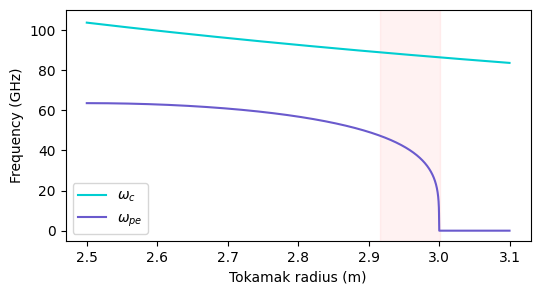

In [4]:
fig,ax = plt.subplots(figsize=(6,3))
ax.plot(np.linspace(2.5,3.1,10000),np.array([wc_WEST(ρ(R)) for R in np.linspace(2.5,3.1,10000)])*ν/k00,label='$ω_{c}$',c='darkturquoise') # remove *νrel for points^{-1}
ax.plot(np.linspace(2.5,3.1,10000),np.sqrt([wpe2_Parabolic(ρ(R)) for R in np.linspace(2.5,3.1,10000)])*ν/k00,label='$ω_{pe}$',c='slateblue') # remove *νrel for points^{-1}
ax.set_xlabel('Tokamak radius (m)')
ax.set_ylabel('Frequency (GHz)')
#plt.ylabel('Frequency (points$^{-1}$)')
ax.add_patch(Rectangle((Rfromx(Nx),-10),(Rfromx(0)-Rfromx(Nx)),200,color='red',alpha=0.05))
ax.set_ylim(-5,110)
ax.legend()
#ax.set_xlim(2.98,3.02)
plt.show()

Let us use the graph above to consider the study domain (plotted in red in hindsight). Note that in this graph we are probing from the right towards the left (we will flip the orientation later). We can agree that there is not much point in studying further than 2.9m. In fact, to keep it consistent with the mtanh profile case we will consider the cavity up to slightly further than 2.92 m. Additionally, in this case it trivial to chose the domain start at 3 m, with the corresponding ```p0plas``` buffer zone.

Similarly, we don't need an envelope as $n_e(\rho=1)=0$.

Now we need to obtain the relationship between $R$ and $x$.

Firstly, given that for ```k00=0.025``` the wavelength corresponds to $80\pi$ points and as we are assigning this to a $\nu=84.0$ GHz wave, with wavelength $\lambda=\frac{c}{\nu}\approx3.57\cdot10^{-3}$ m, we conclude that 
\begin{equation}
    \frac{\Delta R}{\Delta x}=\frac{k_{00}\lambda}{2\pi}=\frac{c}{80\pi\nu}\approx1.42\cdot10^{-5}\ \mathrm{m/point}
\end{equation}

We consider in this case a 8-9 cm long cavity starting at R=3.00 m. This corresponds to a simulation cavity size of 5633.80 to 6338.03 points. 

We will use ```Nx=6000``` and assign ```p0plas=50```, and the rest of the points will be actual plasma cavity. The mathematical relation between $R$ and $x$, as the growth of $x$ is in the opposite direction to that of $R$, is as follows:

\begin{equation}
    R(x)=3.00-\frac{\Delta R}{\Delta x}(x-\texttt{p0plas})
\end{equation}

Once we have this, the rest is fairly simple. We only need to determine the proving wave's frequencies. Let us plot as well the cut-off frequencies.

In [5]:
def wco_up(wpe2,wc):
    return 0.5*(wc+np.sqrt(wc**2+4*wpe2))
def wco_low(wpe2,wc):
    return 0.5*(-wc+np.sqrt(wc**2+4*wpe2))

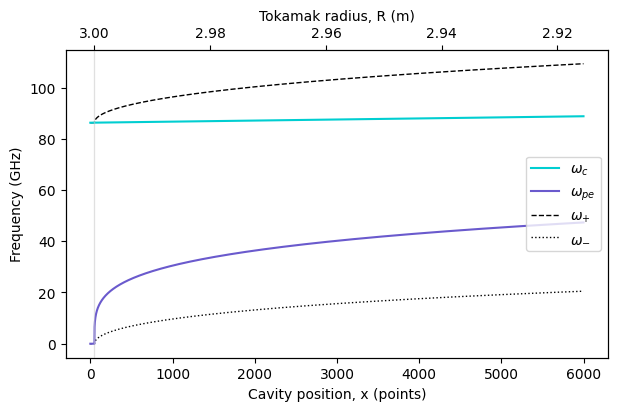

In [6]:
wpe2     = np.array([wpe2_Parabolic(ρ(Rfromx(x))) for x in np.arange(Nx)]) #if x>p0plas else 0
wc       = np.array([wc_WEST(ρ(Rfromx(x))) for x in np.arange(Nx)])

unitsGHz = True

fig,ax = plt.subplots(figsize=(7,4))

ax.set_xlabel('Cavity position, x (points)')
if unitsGHz:
    ax.plot(np.arange(Nx),wc*ν/k00,label='$ω_{c}$',c='darkturquoise')
    ax.plot(np.arange(Nx),np.sqrt(wpe2)*ν/k00,label='$ω_{pe}$',c='slateblue')
    ax.set_ylabel('Frequency (GHz)')
    ax.plot(wco_up(wpe2,wc)*ν/k00,linestyle='dashed',linewidth=1,c='black',label='$ω_{+}$',zorder=1)
    ax.plot(wco_low(wpe2,wc)*ν/k00,linestyle='dotted',linewidth=1,c='black',label='$ω_{-}$',zorder=1)
    #for b in ωb_: ax.axhline(b*ν/k00,linewidth=0.5)
else:
    ax.plot(np.arange(Nx),wc,label='$ω_{c}$',c='darkturquoise')
    ax.plot(np.arange(Nx),np.sqrt(wpe2),label='$ω_{pe}$',c='slateblue')
    ax.set_ylabel('Frequency (points$^{-1}$)')
    ax.plot(wco_up(wpe2,wc),linestyle='dashed',linewidth=1,c='black',label='$ω_{+}$',zorder=1)
    ax.plot(wco_low(wpe2,wc),linestyle='dotted',linewidth=1,c='black',label='$ω_{-}$',zorder=1)
    #for b in ωb_: ax.axhline(b,linewidth=0.5)

axtop = ax.twiny()
axtop.plot(np.linspace(Rfromx(0),Rfromx(Nx),1000),[np.sqrt(wpe2_Parabolic(ρ(R))) for R in np.linspace(Rfromx(0),Rfromx(Nx),1000)],linewidth=0) # remove *νrel for points^{-1}
axtop.invert_xaxis()
axtop.set_xlabel('Tokamak radius, R (m)')
axtop.axvline(3,linewidth=1,color='lightgray',alpha=0.5,zorder=0)
ax.axvline(p0plas,linewidth=0.5,color='lightgray',alpha=0.5,zorder=0)
ax.legend(loc='center right')

# -- Probing frequency check --
#for R in Rc_: axtop.axvline(R,linestyle='dashed',c='gray')
#for w in wb_: ax.axhline(w)

#ax.set_xlim(None,2000)
#axtop.set_xlim(None,Rfromx(2000))

plt.show()

<h3>Expected results and probing the frequency</h3>

As our goal is to plot the time of flight against the cavity position, we are going to establish a list of positions in our cavity of interest. These will be the desired cutoff positions and we will determine the necessary probing frequency through the ```ωco_up``` function. The expected flight times (computed through the WKB approximation) are plotted below.

We can see that we can begin the pulse probes at frequency 0.025 points^{-1} until about 0.031, with extra points in the 0.025 to 0.028 range.

In [7]:
Rc_      = np.array([2.999,2.98,2.92])
Rc_extra = np.array([2.9999,2.99])
#Rc_addit = np.array([2.8])

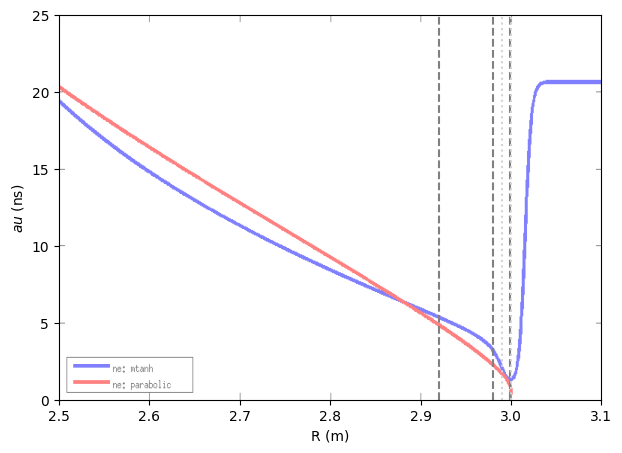

In [8]:
fig,ax = plt.subplots(figsize=(7,5),dpi=100)
img = plt.imread('tau_ini_mtanh.png')
imgGraph = [[39,467],[121,845]]
ax.imshow(img[imgGraph[0][0]:imgGraph[0][1],imgGraph[1][0]:imgGraph[1][1]], extent=[2.5,3.1,0,25], aspect='auto',alpha=0.5)
ax.set_ylabel('$\tau$ (ns)')
ax.set_xlabel('R (m)')
#ax.set_ylim(0,5)
#ax.set_xlim(2.95,3.05)

for R in Rc_: ax.axvline(R,linestyle='dashed',c='gray')
for R in Rc_extra: ax.axvline(R,linestyle='dotted',c='lightgray')
#ax.axhline(8.4)
plt.show()

We will use the avobe graph to determine the number of time iterations for each simulation for time efficiency's sake. For that, though, we need to determine the change of time units between points$^{-1}$ and seconds.

We know that due to the magic step, ```k00=ω```, which we assigned to 84 GHz. Thus a period in points units is $\frac{2\pi}{k_{00}}$, and in seconds it is $T=(84\ \text{GHz})^{-1}$. Hence

\begin{equation}
    \frac{\Delta t}{\Delta x}=\frac{(84\ \text{GHz})^{-1}}{\frac{2\pi}{k_{00}}}=\frac{k_{00}}{2\pi\cdot(84\ \text{GHz})}=4.7367\cdot10^{-5}\ \text{ns/point}
\end{equation}

In [9]:
Δt_Δx = k00/(2*np.pi*ν) # ns per point

# We determine (by hand) the expected time of flight in nanoseconds
τtheory_      = np.array([1.1,2.25,4.85])
τtheory_extra = np.array([1,1.7])
#τtheory_addit      = np.array([8.4])

# We convert to simulation points
τpred_      = τtheory_/Δt_Δx
τpred_extra = τtheory_extra/Δt_Δx

In [10]:
wb_      = [wco_up(wpe2_Parabolic(ρ(R)),wc_WEST(ρ(R))) for R in Rc_]
wb_extra = [wco_up(wpe2_Parabolic(ρ(R)),wc_WEST(ρ(R))) for R in Rc_extra]

In [11]:
λinσ = 150
σ  = λinσ*2*np.pi/k00
Nt = int((8*σ)*1.05)

genData=0

if genData:
    
    plasWESTparab = plasma_domain(wpe2,wc,Nx,p0plas,k00,ν)

    folderpath  = 'Results/WEST/'
    filename    = 'WESTParabolicProfile_TestFlightTime.pickle'
    
    
    try: df = pd.read_pickle(folderpath+filename)
    except: 
        df = pd.DataFrame({'Rc':[0],'probFrec (points)':[0],'Source':[np.zeros(Nt)],'Reflected':[np.zeros(Nt)],
                           'Transmitted':[np.zeros(Nt)],'KineticTime':[np.zeros((2,Nt))]})
        df.to_pickle(folderpath+filename)
    
    del(df)

    for i in range(len(wb_)):
        
        print('Probing frequency: %.5f points^{-1}, %.2f GHz'%(wb_[i],wb_[i]*ν/k00))
        print('Cutoff position: %.3f'%(Rc_[i]))

        # -- Source --
        
        σ  = λinσ*2*np.pi/wb_[i]
        Nt = int((8*σ+τpred_[i])*1.05)
        
     ### -- WAVE SIMULATION -- ####
        
        wv = wavePlasma(plasWESTparab,
                       lambda t: k0i(t,wb_[i]),
                       lambda t,ki: gaussSource(t,ki,σ)*sinSource(t,ki))
        
        # -- Running the simulation --

        wv.waveEvPlasma(Nt,plot=False,Hist=True)

        df=pd.read_pickle(folderpath+filename)
        df.loc[len(df)]=[Rc_[i],wb_[i],
                         [wv.sExc(t,wv.ki(t)) for t in range(Nt)],
                         wv.Hist[1][1],wv.Hist[2][1],wv.Hist[3]]
        df.to_pickle(folderpath+filename)
        del(df)
        print('                                                                ',end='\r')
        print('Done!')